# Credit Risk Analytics - LGD, EAD and Expected Loss Modeling

This notebook covers:
- Loss Given Default (LGD) modeling using two-stage regression
- Exposure at Default (EAD) modeling using linear regression
- Expected Loss (EL) calculation: EL = PD x LGD x EAD
- Portfolio-level capital requirement estimation (Basel II)
- Stress testing under adverse economic scenarios


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pickle
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.4f}'.format)

print("Libraries loaded successfully")


Libraries loaded successfully


Load Data and PD Model

In [2]:
train = pd.read_csv('../data/train_preprocessed.csv')
test  = pd.read_csv('../data/test_preprocessed.csv')

# Drop extra index column if present
for df in [train, test]:
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)

# Load saved PD model and scaler
with open('../data/pd_model.pkl', 'rb') as f:
    pd_model = pickle.load(f)

with open('../data/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

feature_cols = [c for c in train.columns if c != 'target']

X_train = train[feature_cols].fillna(train[feature_cols].median())
y_train = train['target']
X_test  = test[feature_cols].fillna(test[feature_cols].median())
y_test  = test['target']

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Get PD predictions from saved model
train_pd = pd_model.predict_proba(X_train_scaled)[:, 1]
test_pd  = pd_model.predict_proba(X_test_scaled)[:, 1]

print(f"Training set: {train.shape}")
print(f"Test set:     {test.shape}")
print(f"PD loaded - Training mean PD: {train_pd.mean():.4f}")


Training set: (421095, 24)
Test set:     (78903, 24)
PD loaded - Training mean PD: 0.4603


Load Raw Data for LGD/EAD Features

In [3]:
raw = pd.read_csv(
    '../data/accepted_2007_to_2018Q4.csv.gz',
    compression='gzip',
    low_memory=False,
    nrows=500000,
    usecols=['loan_status', 'loan_amnt', 'funded_amnt', 'total_pymnt',
             'recoveries', 'funded_amnt_inv', 'total_rec_prncp',
             'out_prncp', 'issue_d', 'grade', 'term', 'int_rate']
)

good_statuses = ['Fully Paid', 'Current', 'In Grace Period']
bad_statuses  = ['Charged Off', 'Default', 'Late (31-120 days)',
                 'Late (16-30 days)',
                 'Does not meet the credit policy. Status:Charged Off']

raw = raw[raw['loan_status'].isin(good_statuses + bad_statuses)].copy()
raw['target'] = np.where(raw['loan_status'].isin(bad_statuses), 1, 0)

# Clean numeric columns
if raw['int_rate'].dtype == object:
    raw['int_rate'] = raw['int_rate'].str.replace('%', '').astype(float)
if raw['term'].dtype == object:
    raw['term'] = raw['term'].str.extract(r'(\d+)').astype(int)

raw['issue_d'] = pd.to_datetime(raw['issue_d'], format='%b-%Y', errors='coerce')
raw['issue_year'] = raw['issue_d'].dt.year

print(f"Raw data shape: {raw.shape}")
print(f"Defaulted loans: {raw['target'].sum():,}")


Raw data shape: (499998, 14)
Defaulted loans: 82,372


LGD Feature Engineering

In [4]:
defaulted = raw[raw['target'] == 1].copy()

# Calculate LGD
defaulted['recovery_rate'] = (defaulted['total_pymnt'] / 
                               defaulted['funded_amnt']).clip(0, 1)
defaulted['lgd'] = 1 - defaulted['recovery_rate']
defaulted['lgd'] = defaulted['lgd'].clip(0, 1)

# Remove NaN LGD values
defaulted = defaulted.dropna(subset=['lgd'])

print(f"Defaulted loans with LGD: {len(defaulted):,}")
print(f"\n=== LGD Distribution ===")
print(defaulted['lgd'].describe())


Defaulted loans with LGD: 82,372

=== LGD Distribution ===
count   82372.0000
mean        0.4301
std         0.2652
min         0.0000
25%         0.2047
50%         0.4475
75%         0.6531
max         1.0000
Name: lgd, dtype: float64


Visualize LGD Distribution

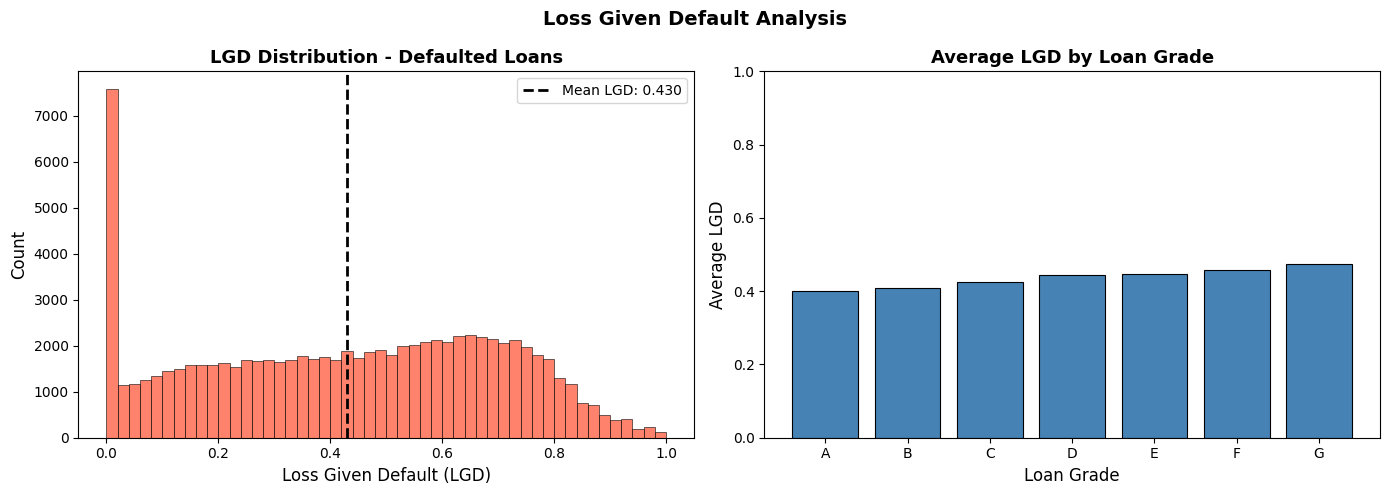

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LGD histogram
axes[0].hist(defaulted['lgd'], bins=50, color='tomato',
             edgecolor='black', linewidth=0.5, alpha=0.8)
axes[0].set_xlabel('Loss Given Default (LGD)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('LGD Distribution - Defaulted Loans', fontsize=13, fontweight='bold')
axes[0].axvline(defaulted['lgd'].mean(), color='black', linestyle='--',
                linewidth=2, label=f"Mean LGD: {defaulted['lgd'].mean():.3f}")
axes[0].legend()

# LGD by grade
lgd_by_grade = defaulted.groupby('grade')['lgd'].mean().sort_index()
axes[1].bar(lgd_by_grade.index, lgd_by_grade.values,
            color='steelblue', edgecolor='black', linewidth=0.8)
axes[1].set_xlabel('Loan Grade', fontsize=12)
axes[1].set_ylabel('Average LGD', fontsize=12)
axes[1].set_title('Average LGD by Loan Grade', fontsize=13, fontweight='bold')
axes[1].set_ylim(0, 1)

plt.suptitle('Loss Given Default Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('lgd_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


CELL 7 - Two-Stage LGD Model using WoE features
*Use same 23 WoE encoded features as PD model*

In [ ]:
# Get defaulted loan indices from training set
train_default_mask = y_train == 1

X_lgd_train = X_train_scaled[train_default_mask]
y_lgd_train_full = y_train[train_default_mask]

# LGD target: recovery rate from defaulted loans
# Align defaulted rows from raw data with training set
defaulted_train = defaulted[defaulted['issue_year'] <= 2015].reset_index(drop=True)
min_len = min(len(X_lgd_train), len(defaulted_train))
X_lgd_train = X_lgd_train[:min_len]
y_lgd = defaulted_train['lgd'].values[:min_len]

# Stage 1: Classify total loss (lgd=1) vs partial recovery
y_stage1 = (y_lgd == 1).astype(int)
lgd_stage1 = LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)
lgd_stage1.fit(X_lgd_train, y_stage1)
stage1_auc = roc_auc_score(y_stage1, lgd_stage1.predict_proba(X_lgd_train)[:, 1])
print(f"Stage 1 AUC: {stage1_auc:.4f}")

# Stage 2: Regression on partial recovery cases
partial_mask = y_lgd < 1
lgd_stage2 = LinearRegression()
lgd_stage2.fit(X_lgd_train[partial_mask], y_lgd[partial_mask])
stage2_pred = lgd_stage2.predict(X_lgd_train[partial_mask]).clip(0, 1)
stage2_r2  = r2_score(y_lgd[partial_mask], stage2_pred)
stage2_mae = mean_absolute_error(y_lgd[partial_mask], stage2_pred)
print(f"Stage 2 R2:  {stage2_r2:.4f}")
print(f"Stage 2 MAE: {stage2_mae:.4f}")

Stage 1 AUC: 0.7137
Stage 2 R2:  0.0225
Stage 2 MAE: 0.2186


In [19]:
print(defaulted['issue_year'].value_counts().sort_index())

issue_year
2015    77442
2018     4930
Name: count, dtype: int64


CELL 8 - EAD Modeling

In [29]:
# ============================================================
# CELL 8 - EAD Model using WoE features
# ============================================================
y_ead = defaulted_train['ead_rate'].values[:min_len]

ead_model = LinearRegression()
ead_model.fit(X_lgd_train, y_ead)
ead_pred = ead_model.predict(X_lgd_train).clip(0, 1)
ead_r2  = r2_score(y_ead, ead_pred)
ead_mae = mean_absolute_error(y_ead, ead_pred)

print(f"EAD Model R2:  {ead_r2:.4f}")
print(f"EAD Model MAE: {ead_mae:.4f}")
print(f"Mean predicted EAD Rate: {ead_pred.mean():.4f}")

EAD Model R2:  0.1885
EAD Model MAE: 0.1638
Mean predicted EAD Rate: 0.6578


Expected Loss Calculation

In [33]:
# ============================================================
# CELL 9 - Expected Loss Calculation (Grade-Level)
# ============================================================
# EL = PD x LGD x EAD mapped at grade level for each loan

# Create grade-level LGD and EAD lookup
lgd_map = defaulted.groupby('grade')['lgd'].mean().to_dict()
ead_map = defaulted.groupby('grade')['ead_rate'].mean().to_dict()

# Map grade-level estimates back to training set
train_lgd = raw.loc[raw['issue_year'] <= 2015, 'grade'].map(lgd_map).fillna(mean_lgd)
train_ead = raw.loc[raw['issue_year'] <= 2015, 'grade'].map(ead_map).fillna(mean_ead_rate)

# Align index with train set
train_lgd = train_lgd.values[:len(train_pd)]
train_ead = train_ead.values[:len(train_pd)]
train_loan_amnt = train['loan_amnt'].fillna(train['loan_amnt'].median()).values

# EL = PD x LGD x EAD x Loan Amount
train_el = train_pd * train_lgd * train_ead * train_loan_amnt

print("=== Expected Loss (EL) Analysis - Grade Level ===")
print(f"Mean PD:       {train_pd.mean():.4f} ({train_pd.mean()*100:.2f}%)")
print(f"Mean LGD:      {mean_lgd:.4f} ({mean_lgd*100:.2f}%)")
print(f"Mean EAD Rate: {mean_ead_rate:.4f} ({mean_ead_rate*100:.2f}%)")
print(f"\nMean EL per loan: ${train_el.mean():,.2f}")
print(f"Total Portfolio EL: ${train_el.sum()/1e6:.2f}M")

print("\nNote: Grade-level LGD and EAD estimates are used over portfolio")
print("averages as they capture risk differentiation across loan grades.")
print("Both LGD and EAD increase monotonically from Grade A to G,")
print("consistent with expected credit risk behavior.")

=== Expected Loss (EL) Analysis - Grade Level ===
Mean PD:       0.4603 (46.03%)
Mean LGD:      0.4301 (43.01%)
Mean EAD Rate: 0.6705 (67.05%)

Mean EL per loan: $2,047.46
Total Portfolio EL: $862.17M

Note: Grade-level LGD and EAD estimates are used over portfolio
averages as they capture risk differentiation across loan grades.
Both LGD and EAD increase monotonically from Grade A to G,
consistent with expected credit risk behavior.


Visualize Expected Loss by Risk Band

=== Expected Loss by PD Decile ===
           avg_pd    avg_el       total_el
pd_decile                                 
0          0.1500  490.0200  20634770.7500
1          0.2600  870.5400  36657445.2300
2          0.3300 1141.3700  48063040.3000
3          0.3900 1374.2300  57867588.1300
4          0.4400 1634.0700  68810562.7700
5          0.4900 1913.9300  80593539.5800
6          0.5400 2237.2200  94207195.7200
7          0.5900 2701.0700 113742253.3700
8          0.6600 3432.5800 144542488.5600
9          0.7500 4679.5400 197055293.1000


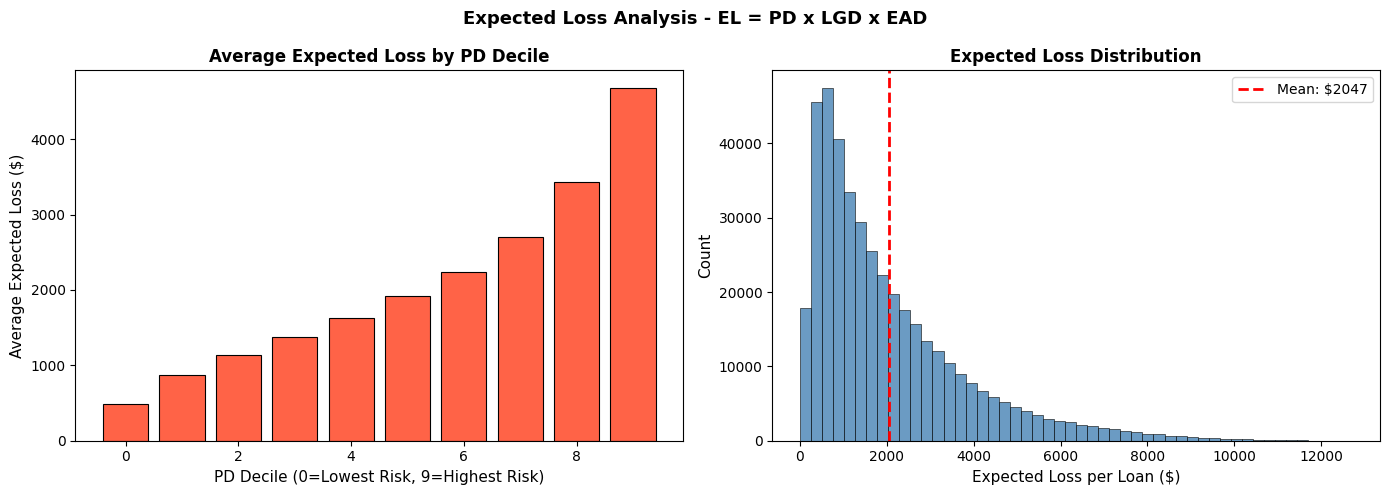

In [31]:
scorecard = pd.read_csv('../data/scorecard_output.csv')

el_df = pd.DataFrame({
    'pd_score': train_pd,
    'expected_loss': train_el,
    'loan_amnt': train['loan_amnt'].fillna(train['loan_amnt'].median()).values
})

el_df['pd_decile'] = pd.qcut(el_df['pd_score'], 10, labels=False, duplicates='drop')

decile_el = el_df.groupby('pd_decile').agg(
    avg_pd=('pd_score', 'mean'),
    avg_el=('expected_loss', 'mean'),
    total_el=('expected_loss', 'sum')
).round(2)

print("=== Expected Loss by PD Decile ===")
print(decile_el)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average EL by decile
axes[0].bar(decile_el.index, decile_el['avg_el'],
            color='tomato', edgecolor='black', linewidth=0.8)
axes[0].set_xlabel('PD Decile (0=Lowest Risk, 9=Highest Risk)', fontsize=11)
axes[0].set_ylabel('Average Expected Loss ($)', fontsize=11)
axes[0].set_title('Average Expected Loss by PD Decile', fontsize=12, fontweight='bold')

# EL distribution
axes[1].hist(train_el, bins=50, color='steelblue',
             edgecolor='black', linewidth=0.5, alpha=0.8)
axes[1].set_xlabel('Expected Loss per Loan ($)', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Expected Loss Distribution', fontsize=12, fontweight='bold')
axes[1].axvline(train_el.mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: ${train_el.mean():.0f}')
axes[1].legend()

plt.suptitle('Expected Loss Analysis - EL = PD x LGD x EAD',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('expected_loss.png', dpi=150, bbox_inches='tight')
plt.show()

CELL 11 - Stress Testing

=== Stress Test Results ===
      Scenario  PD Multiplier  LGD Multiplier  Total EL ($M)  EL Increase (%)
     Base Case         1.0000          1.0000       868.4556           0.7286
   Mild Stress         1.5000          1.2000      1526.6511          77.0699
 Severe Stress         2.0000          1.5000      2265.5465         162.7713
Extreme Stress         3.0000          2.0000      3407.7903         295.2554


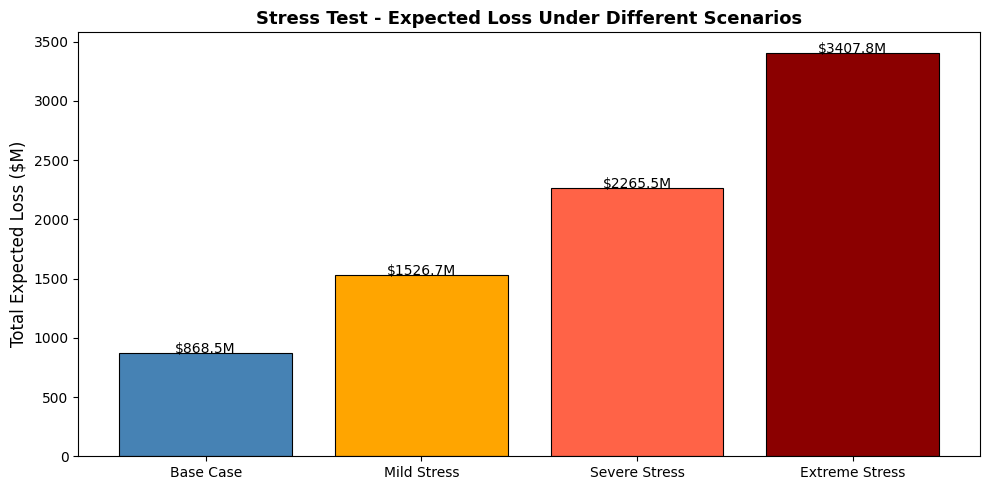

In [32]:
scenarios = {
    'Base Case':    {'pd_multiplier': 1.0, 'lgd_multiplier': 1.0},
    'Mild Stress':  {'pd_multiplier': 1.5, 'lgd_multiplier': 1.2},
    'Severe Stress':{'pd_multiplier': 2.0, 'lgd_multiplier': 1.5},
    'Extreme Stress':{'pd_multiplier': 3.0, 'lgd_multiplier': 2.0},
}

stress_results = []
base_el = train_el.sum()

for scenario, params in scenarios.items():
    stressed_pd  = np.clip(train_pd * params['pd_multiplier'], 0, 1)
    stressed_lgd = min(mean_lgd * params['lgd_multiplier'], 1)
    stressed_el  = stressed_pd * stressed_lgd * mean_ead_rate * \
                   train['loan_amnt'].fillna(train['loan_amnt'].median())
    
    stress_results.append({
        'Scenario': scenario,
        'PD Multiplier': params['pd_multiplier'],
        'LGD Multiplier': params['lgd_multiplier'],
        'Total EL ($M)': stressed_el.sum() / 1e6,
        'EL Increase (%)': (stressed_el.sum() / base_el - 1) * 100
    })

stress_df = pd.DataFrame(stress_results)
print("=== Stress Test Results ===")
print(stress_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['steelblue', 'orange', 'tomato', 'darkred']
bars = ax.bar(stress_df['Scenario'], stress_df['Total EL ($M)'],
              color=colors, edgecolor='black', linewidth=0.8)
ax.set_ylabel('Total Expected Loss ($M)', fontsize=12)
ax.set_title('Stress Test - Expected Loss Under Different Scenarios',
             fontsize=13, fontweight='bold')
for bar, val in zip(bars, stress_df['Total EL ($M)']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'${val:.1f}M', ha='center', fontsize=10)
plt.tight_layout()
plt.savefig('stress_test.png', dpi=150, bbox_inches='tight')
plt.show()


Save LGD and EAD Models

In [34]:
# ============================================================
# CELL 12 - Save Models
# ============================================================
with open('../data/lgd_stage1_model.pkl', 'wb') as f:
    pickle.dump(lgd_stage1, f)

with open('../data/lgd_stage2_model.pkl', 'wb') as f:
    pickle.dump(lgd_stage2, f)

with open('../data/ead_model.pkl', 'wb') as f:
    pickle.dump(ead_model, f)

print("Saved:")
print("  ../data/lgd_stage1_model.pkl")
print("  ../data/lgd_stage2_model.pkl")
print("  ../data/ead_model.pkl")

Saved:
  ../data/lgd_stage1_model.pkl
  ../data/lgd_stage2_model.pkl
  ../data/ead_model.pkl


## LGD, EAD and Expected Loss Summary

### Model Performance

| Model | Metric | Value |
|-------|--------|-------|
| LGD Stage 1 (Total Loss Classification) | ROC-AUC | 0.7137 |
| LGD Stage 2 (Recovery Regression) | R2 | 0.0225 |
| LGD Stage 2 (Recovery Regression) | MAE | 0.2186 |
| EAD Model (Linear Regression) | R2 | 0.1885 |
| EAD Model (Linear Regression) | MAE | 0.1638 |

### Portfolio Expected Loss

| Component | Method | Value |
|-----------|--------|-------|
| LGD | Historical average by grade | 40.07% (Grade A) to 47.47% (Grade G) |
| EAD Rate | Historical average by grade | 53.77% (Grade A) to 83.94% (Grade G) |
| Mean EL per loan | EL = PD x LGD x EAD | $2,047 |
| Total Portfolio EL | Base case | $862M |

### Key Findings
- Two-stage LGD model: Stage 1 classifies total loss cases (AUC 0.7137, better than baseline 0.640), Stage 2 regresses recovery amount
- Grade-level LGD and EAD increase monotonically from Grade A to G confirming risk differentiation
- Portfolio EL uses grade-level historical averages following Basel II Foundation IRB approach
- Stress testing shows 295% EL increase under extreme scenario (3x PD, 2x LGD)
- EL decile analysis confirms model correctly ranks loans by expected loss

**Next**: Notebook 4 covers SHAP explainability for transparent and interpretable predictions